In [1]:
from fastai.vision import *
from fastai.metrics import accuracy
from fastai.basic_data import *
import pandas as pd

from utils import *

## Data

In [2]:
df = pd.read_csv('data/train.csv')
df.head()

,Image,Id
0,0000e88ab.jpg,w_f48451c
1,0001f9222.jpg,w_c3d896a
2,00029d126.jpg,w_20df2c5
3,00050a15a.jpg,new_whale
4,0005c1ef8.jpg,new_whale


In [3]:
df.Id.value_counts().head()

new_whale    9664
w_23a388d      73
w_9b5109b      65
w_9c506f6      62
w_0369a5c      61
Name: Id, dtype: int64

In [4]:
(df.Id == 'new_whale').mean()

0.3810575292772367

In [5]:
(df.Id.value_counts() == 1).mean()

0.4141858141858142

In [6]:
df.Id.nunique()

5005

In [7]:
df.shape

(25361, 2)

In [8]:
fn2label = {row[1].Image: row[1].Id for row in df.iterrows()}

In [9]:
SZ = 448
BS = 31
NUM_WORKERS = 12
SEED = 0

In [10]:
data = (
    ImageItemList
        .from_folder('data/train-extracted-448')
        .random_split_by_pct(seed=SEED)
        .label_from_func(lambda path: fn2label[path.name])
        .add_test(ImageItemList.from_folder('data/test-extracted-448'))
        .transform(get_transforms(do_flip=False, max_zoom=1, max_warp=0, max_rotate=2), size=SZ, resize_method=ResizeMethod.SQUISH)
        .databunch(bs=BS, num_workers=NUM_WORKERS, path='data')
)

/home/m090009/anaconda3/envs/fastai/lib/python3.7/site-packages/fastai/data_block.py:474: UserWarning: You are labelling your items with CategoryList.
Your valid set contained the folowing unknown labels, the corresponding items have been discarded.
w_0e8341d, w_16fa149, w_bb9497e, w_919f33b, w_939a3c7...
  if getattr(ds, 'warn', False): warn(ds.warn)


In [11]:
data

ImageDataBunch;

Train: LabelList
y: CategoryList (20288 items)
[Category new_whale, Category w_2103ca8, Category w_7f4e251, Category w_d9cdc09, Category w_dc23fbc]...
Path: data/train-extracted-448
x: ImageItemList (20288 items)
[Image (3, 448, 448), Image (3, 448, 448), Image (3, 448, 448), Image (3, 448, 448), Image (3, 448, 448)]...
Path: data/train-extracted-448;

Valid: LabelList
y: CategoryList (4535 items)
[Category w_f276da3, Category new_whale, Category new_whale, Category w_38c6a8d, Category w_b6ad668]...
Path: data/train-extracted-448
x: ImageItemList (4535 items)
[Image (3, 448, 448), Image (3, 448, 448), Image (3, 448, 448), Image (3, 448, 448), Image (3, 448, 448)]...
Path: data/train-extracted-448;

Test: LabelList
y: EmptyLabelList (7959 items)
[EmptyLabel , EmptyLabel , EmptyLabel , EmptyLabel , EmptyLabel ]...
Path: .
x: ImageItemList (7959 items)
[Image (3, 448, 448), Image (3, 448, 448), Image (3, 448, 448), Image (3, 448, 448), Image (3, 448, 448)]...
Path: data/t

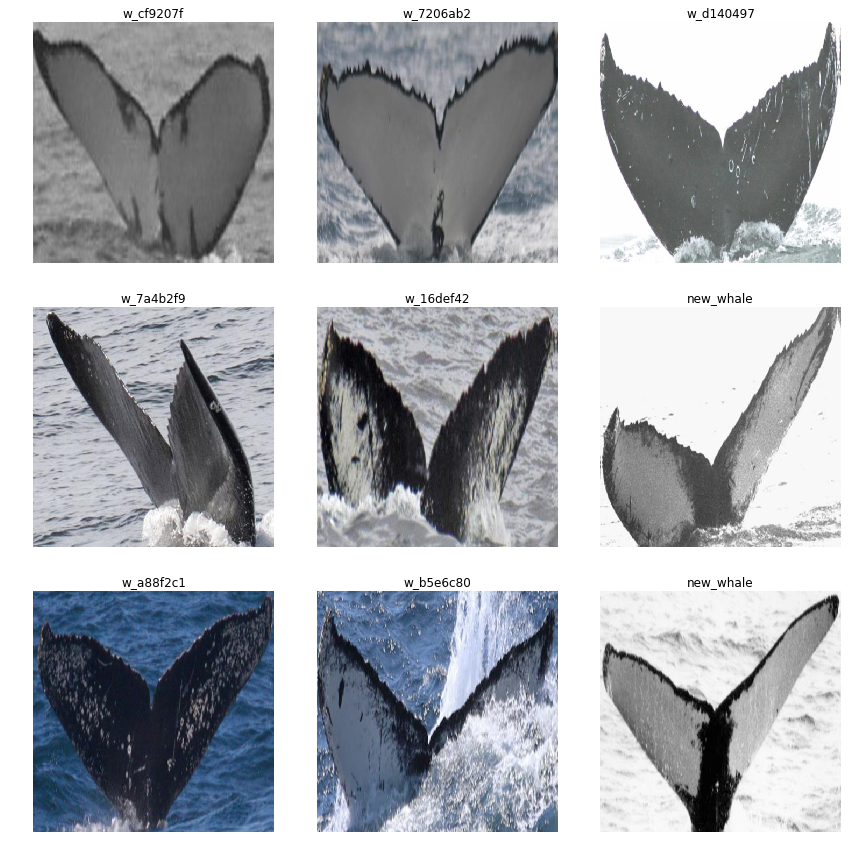

In [85]:
data.show_batch(rows=3)

In [86]:
name = f'res50-{SZ}'

In [87]:
from functools import partial
AdamW16 = partial(torch.optim.Adam, betas=(0.9,0.99), eps=1e-4)

learn = create_cnn(data, models.resnet50, metrics=[accuracy, map5], opt_func=AdamW16)

# learn = create_cnn(data, models.resnet50, metrics=[accuracy, map5])


In [88]:
learn.to_fp16()
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,accuracy,map5


Traceback (most recent call last):
  File "/home/m090009/anaconda3/envs/fastai/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/m090009/anaconda3/envs/fastai/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/m090009/anaconda3/envs/fastai/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/m090009/anaconda3/envs/fastai/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


KeyboardInterrupt: 

In [40]:
learn.to_fp16()
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,accuracy,map5
1,6.005003,4.658051,0.440893,0.463018
2,4.821143,4.409645,0.452496,0.480874


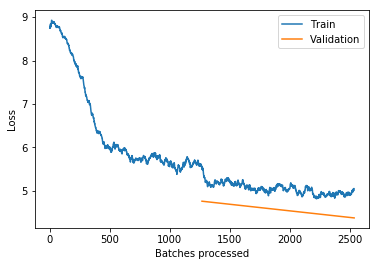

In [82]:
learn.recorder.plot_losses()

In [20]:
learn.save(f'{name}-stage-1')

In [21]:
learn.unfreeze()

In [22]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


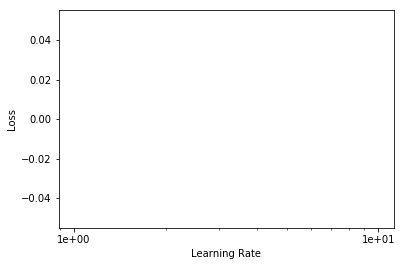

In [23]:
learn.recorder.plot()

In [24]:
max_lr = 1e-4
lrs = [max_lr / 100, max_lr / 10, max_lr]

In [25]:
learn.fit_one_cycle(5, lrs)

epoch,train_loss,valid_loss,accuracy,map5
1,nan,nan,0.433012,0.433012
2,nan,nan,0.433012,0.433012
3,nan,nan,0.433012,0.433012
4,nan,nan,0.433012,0.433012
5,nan,nan,0.433012,0.433012


In [ ]:
learn.save(f'{name}-stage-2')

In [ ]:
learn.recorder.plot_losses()

In [ ]:
preds, _ = learn.get_preds(DatasetType.Test)

In [ ]:
mkdir -p subs

In [ ]:
def create_submission(preds, data, name, no_bbox_test_images,classes=None):
    if not classes: classes = data.classes
    images = [path.name for path in data.test_ds.x.items]
    images.extend(no_bbox_test_images)
    
    sub = pd.DataFrame({'Image': images})
    print('hello')
    top5 = top_5_pred_labels(preds, classes)
    top5.extend([' '.join(['new_whale', 'new_whale','new_whale','new_whale','new_whale']) for n in no_bbox_test_images])
    sub['Id'] = top5
    sub.to_csv(f'subs/{name}.csv.gz', index=False, compression='gzip')

In [ ]:
no_bbox_test_images = ['6a72d84ca.jpg']
create_submission(preds, learn.data, name, no_bbox_test_images)

In [ ]:
pd.read_csv(f'subs/{name}.csv.gz').head()

In [ ]:
pd.read_csv(f'subs/{name}.csv.gz').tail

In [ ]:
!kaggle competitions submit -c humpback-whale-identification -f subs/{name}.csv.gz -m "{name}"

In [ ]:
pd.read_csv(f'subs/{name}.csv.gz').shape